# 1. Assignment: CIFAR-10 Classification

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import datetime

%load_ext tensorboard

/Users/christinearnoldt/mambaforge/envs/iannwtf_/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
SHUFFLE_BUFFER_SIZE = 1000
BATCH_SIZE = 64
LEARNING_RATE = 0.001

## 1.1 Prepare the Dataset

First familiarise yourself with the dataset. It is included as a TensorFlow
Dataset but can also be obtained from other sources. Try to understand how it
works (information in the data, dataset size, image size, are there color chan-
nels, type the data is stored as, etc.). Understanding the data you are working
with and applying respective preprocessing steps is a major part of the process
for real life applications.
Now that you familiarised yourself with it, load the data and apply respective
preprocessing steps using a data pipeline (In case of problems refer to your old
homework tasks or the Courseware). 1 Visualize a sample of the dataset

### Familiarize with dataset and visualize samples

tfds.core.DatasetInfo(
    name='cifar10',
    full_name='cifar10/3.0.2',
    description="""
    The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.
    """,
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    data_dir='/Users/christinearnoldt/tensorflow_datasets/cifar10/3.0.2',
    file_format=tfrecord,
    download_size=162.17 MiB,
    dataset_size=132.40 MiB,
    features=FeaturesDict({
        'id': Text(shape=(), dtype=string),
        'image': Image(shape=(32, 32, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=50000, num_shards=1>,
    },
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
     

2023-12-10 18:05:45.994968: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-12-10 18:05:45.994991: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-12-10 18:05:45.994997: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-12-10 18:05:45.995028: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-10 18:05:45.995045: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-12-10 18:05:46.091142: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected tr

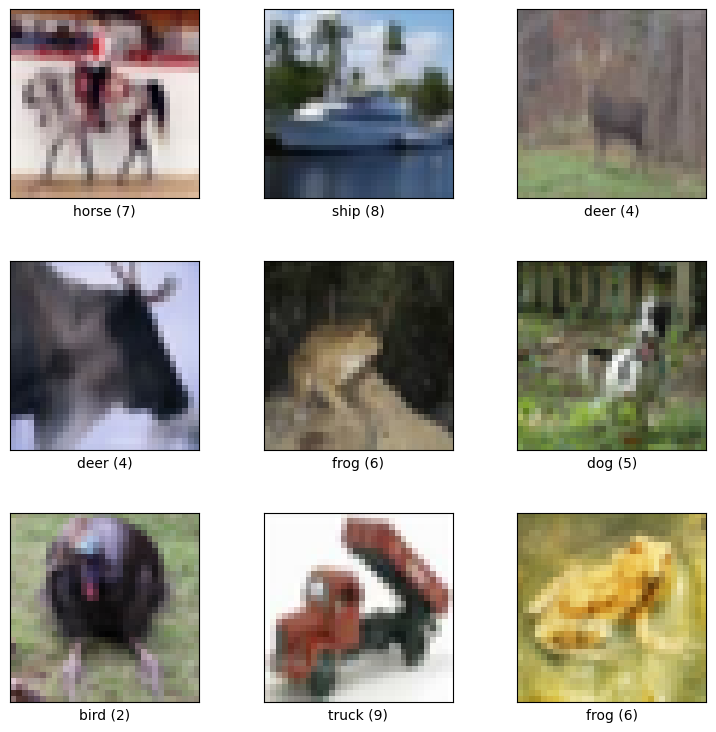

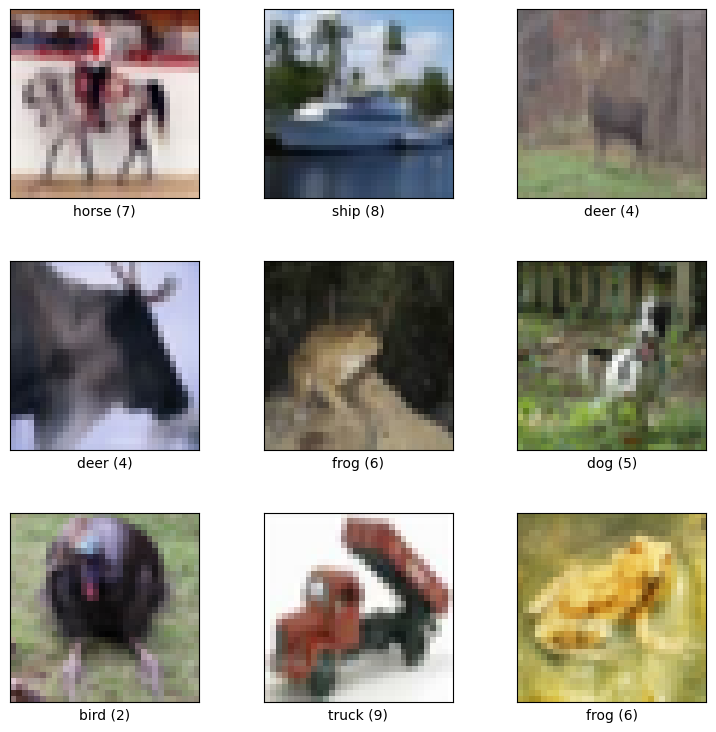

In [4]:
(train_data, test_data), ds_info = tfds.load(name='cifar10',
                                                split=['train','test'],
                                                as_supervised=True,
                                                with_info=True)
print(ds_info)
tfds.show_examples(train_data, ds_info)

### Prepare preprocessing

In [5]:
def preprocessing(img,label):
    img = tf.cast(img, tf.float32)
    img = (img/128) -1
    label = tf.one_hot(label, depth=10)
    return img, label


def load_and_prep_cifar(batch_size, shuffle_buffer_size):
    (train_data, test_data), ds_info = tfds.load(name='cifar10',
                                                split=['train','test'],
                                                as_supervised=True,
                                                with_info=True)
    train_data = train_data.map(lambda img, label: preprocessing(img,label))
    test_data = test_data.map(lambda img, label: preprocessing(img,label))
    train_data = train_data.shuffle(shuffle_buffer_size).batch(batch_size).prefetch(20)
    test_data = test_data.batch(batch_size).prefetch(20)
    return train_data, test_data, ds_info

In [6]:
train_data, test_data, ds_info = load_and_prep_cifar(batch_size=BATCH_SIZE, shuffle_buffer_size=SHUFFLE_BUFFER_SIZE)

## 1.2 The CNN Model

Build a Convolutional Neural Network inspired by the information gained in
this weeks Courseware. You are going to need more than the dense-layers used
so far. Start with a basic structure and don’t necessarily think about optimizing
the architecture too much, as this will be part of the last step. 

In [7]:
class CNN_Model(tf.keras.Model):
    def __init__(self, size_of_blocks: [int], lr, opt):
        super(CNN_Model, self).__init__()
        
        if opt == 'sgd':
            self.optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=lr)
        else:
            self.optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr)
        
        self.metrics_list = [
                        tf.keras.metrics.Mean(name="loss"),
                        tf.keras.metrics.CategoricalAccuracy(name="acc"),
                       ]
        
        self.loss_f = tf.keras.losses.CategoricalCrossentropy()
        
        self.model_layers = []
        
        for block in range(len(size_of_blocks)):
            self.model_layers.append(tf.keras.layers.Conv2D(activation="relu", filters=size_of_blocks[block], kernel_size=3, padding="same"))
            self.model_layers.append(tf.keras.layers.Conv2D(activation="relu", filters=size_of_blocks[block], kernel_size=3, padding="same"))
            self.model_layers.append(tf.keras.layers.Conv2D(activation="relu", filters=size_of_blocks[block], kernel_size=3, padding="same"))
            self.model_layers.append(tf.keras.layers.AvgPool2D(pool_size=(2,2), strides=(2,2)))
        self.global_pooling = tf.keras.layers.GlobalAveragePooling2D()
        self.output_layer = tf.keras.layers.Dense(10, activation='softmax')
       
    @tf.function
    def call(self, x):
        for layer in self.model_layers:
            x = layer(x)
        x = self.global_pooling(x)
        output = self.output_layer(x)
        return output
    
    def reset_metrics(self):
        for metric in self.metrics_list:
            metric.reset_states()
            
            
    @tf.function
    def train_step(self, data):
        x, target = data
        with tf.GradientTape() as tape:
            pred = self(x)
            loss = self.loss_f(target, pred) + tf.reduce_sum(self.losses)
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(grads_and_vars=zip(gradients, self.trainable_variables))
        
        self.metrics[0].update_state(loss)
        
        for metric in self.metrics[1:]:
            metric.update_state(target, pred)
        return {m.name: m.result() for m in self.metrics}
    
    @tf.function
    def test_step(self, data):
        x, target = data
        pred = self(x)
        loss = self.loss_f(target, pred) + tf.reduce_sum(self.losses)
        
        self.metrics[0].update_state(loss)
        
        for metric in self.metrics[1:]:
            metric.update_state(target, pred)
        return {m.name: m.result() for m in self.metrics}

In [8]:
model = CNN_Model(size_of_blocks=[5,10,32,64], lr=LEARNING_RATE, opt='adam')

## 1.3 Training the network

Define a training loop function. Define your hyperparameters, think of an ap-
propriate loss function and optimizer and initialize everything. Store loss and
accuracy for training and test data. Training your network for a maximum of
15 epochs should be enough.

In [9]:
# Define where to save the log
config_name= "Run-1"
current_time_run1 = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

train_log_path = f"logs/{config_name}/{current_time_run1}/train"
test_log_path = f"logs/{config_name}/{current_time_run1}/val"

# log writer for training metrics
train_summary_writer = tf.summary.create_file_writer(train_log_path)

# log writer for validation metrics
test_summary_writer = tf.summary.create_file_writer(test_log_path)

In [10]:
import tqdm

def training_loop(model, train, test, epochs, train_summary_writer, test_summary_writer):
    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []
    for epoch in range(epochs):
        
        #Training
        for data in tqdm.tqdm(train, position=0, leave=True, desc=f"Epoch {epoch}"):
            metrics = model.train_step(data)
            with train_summary_writer.as_default():
                for metric in model.metrics:
                    tf.summary.scalar(f"{metric.name}", metric.result(), step=epoch)
        
        train_loss.append(metrics["loss"].numpy())
        train_acc.append(metrics["acc"].numpy())
        
        # print the metrics
        print([f"{key}: {value.numpy()}" for (key, value) in metrics.items()])
        
        # reset all metrics (requires a reset_metrics method in the model)
        model.reset_metrics()

        # Validation:
        for data in test:
            metrics = model.test_step(data)

            # logging the validation metrics to the log file which is used by tensorboard
            with test_summary_writer.as_default():
                for metric in model.metrics:
                    tf.summary.scalar(f"{metric.name}", metric.result(), step=epoch)
        
        val_loss.append(metrics["loss"].numpy())
        val_acc.append(metrics["acc"].numpy())
        print([f"val_{key}: {value.numpy()}" for (key, value) in metrics.items()])

        # reset all metrics
        model.reset_metrics()
    return train_loss, train_acc, val_loss, val_acc

In [11]:
train, test, info = load_and_prep_cifar(batch_size=BATCH_SIZE, shuffle_buffer_size=SHUFFLE_BUFFER_SIZE)
model = CNN_Model(size_of_blocks=[5,10,32,64], lr=LEARNING_RATE, opt='adam')
train_losses, train_accuracies, val_losses, val_accuracies = training_loop(model, train, test, 15, train_summary_writer, test_summary_writer)

Epoch 0: 100%|██████████| 782/782 [00:17<00:00, 44.63it/s]


['loss: 1.8535841703414917', 'acc: 0.2974399924278259']
['val_loss: 1.6210006475448608', 'val_acc: 0.4018000066280365']


Epoch 1: 100%|██████████| 782/782 [00:15<00:00, 52.11it/s]


['loss: 1.5624489784240723', 'acc: 0.42179998755455017']
['val_loss: 1.4648581743240356', 'val_acc: 0.46209999918937683']


Epoch 2: 100%|██████████| 782/782 [00:14<00:00, 52.85it/s]


['loss: 1.3951703310012817', 'acc: 0.4867599904537201']
['val_loss: 1.3557785749435425', 'val_acc: 0.5121999979019165']


Epoch 3: 100%|██████████| 782/782 [00:14<00:00, 53.02it/s]


['loss: 1.2647559642791748', 'acc: 0.539680004119873']
['val_loss: 1.2246348857879639', 'val_acc: 0.5557000041007996']


Epoch 4: 100%|██████████| 782/782 [00:14<00:00, 53.04it/s]


['loss: 1.1652822494506836', 'acc: 0.5779600143432617']
['val_loss: 1.1620099544525146', 'val_acc: 0.5817999839782715']


Epoch 5: 100%|██████████| 782/782 [00:14<00:00, 53.28it/s]


['loss: 1.0908781290054321', 'acc: 0.6068000197410583']
['val_loss: 1.1121717691421509', 'val_acc: 0.5958999991416931']


Epoch 6: 100%|██████████| 782/782 [00:14<00:00, 53.11it/s]


['loss: 1.0324920415878296', 'acc: 0.6288400292396545']
['val_loss: 1.0823386907577515', 'val_acc: 0.6105999946594238']


Epoch 7: 100%|██████████| 782/782 [00:14<00:00, 53.22it/s]


['loss: 0.9827747941017151', 'acc: 0.648580014705658']
['val_loss: 1.093729019165039', 'val_acc: 0.6168000102043152']


Epoch 8: 100%|██████████| 782/782 [00:14<00:00, 53.34it/s]


['loss: 0.9338799715042114', 'acc: 0.6664599776268005']
['val_loss: 1.05356764793396', 'val_acc: 0.6331999897956848']


Epoch 9: 100%|██████████| 782/782 [00:14<00:00, 52.97it/s]


['loss: 0.8923562169075012', 'acc: 0.6800400018692017']
['val_loss: 0.9883350729942322', 'val_acc: 0.6560999751091003']


Epoch 10: 100%|██████████| 782/782 [00:14<00:00, 52.97it/s]


['loss: 0.8531957268714905', 'acc: 0.6962000131607056']
['val_loss: 0.995057225227356', 'val_acc: 0.6547999978065491']


Epoch 11: 100%|██████████| 782/782 [00:14<00:00, 53.17it/s]


['loss: 0.8154521584510803', 'acc: 0.7091000080108643']
['val_loss: 1.043988823890686', 'val_acc: 0.6413999795913696']


Epoch 12: 100%|██████████| 782/782 [00:14<00:00, 53.50it/s]


['loss: 0.7776486277580261', 'acc: 0.7221199870109558']
['val_loss: 1.1007083654403687', 'val_acc: 0.6430000066757202']


Epoch 13: 100%|██████████| 782/782 [00:14<00:00, 53.31it/s]


['loss: 0.7452452182769775', 'acc: 0.7334799766540527']
['val_loss: 1.0167083740234375', 'val_acc: 0.6622999906539917']


Epoch 14: 100%|██████████| 782/782 [00:14<00:00, 53.73it/s]


['loss: 0.7148342132568359', 'acc: 0.7440000176429749']
['val_loss: 1.0491082668304443', 'val_acc: 0.6517000198364258']


## 1.4 Visualization

After training visualize the performance of your model and the values that you
collected during training and testing.

In [12]:
%tensorboard --logdir logs

In [13]:
import matplotlib.pyplot as plt
def visualization (train_losses, train_accuracies, val_losses, val_accuracies):
    """ Visualizes accuracy and loss for training and test data using
        the mean of each epoch.
        
        Loss is displayed in a regular line, accuracy in a dotted line.
        Training data is displayed in blue, test data in red.
    
    Parameters
    ----------
    train_losses : numpy . ndarray
    training losses
    train_accuracies : numpy . ndarray
    training accuracies
    val_losses : numpy . ndarray
    val losses
    val_accuracies : numpy . ndarray
    val accuracies
    """
    #plt.figure()
    line1, = plt.plot(train_losses, "b-")
    line2, = plt.plot(val_losses, "r-")
    line3, = plt.plot(train_accuracies, "b:")
    line4, = plt.plot(val_accuracies, "r:")
    plt.xlabel("Training steps")
    plt.ylabel("Loss / Accuracy")
    plt.legend((line1, line2, line3, line4), ("training loss", "validation loss", "train accuracy", "validation accuracy"))
    plt.show()

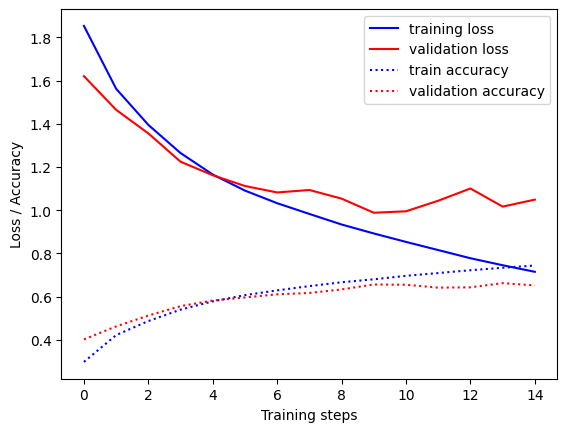

In [14]:
visualization(train_losses, train_accuracies, val_losses, val_accuracies)

# 2 Adjust hyperparameters and architecture

Now it is time to learn about the influence hyperparameter and training choices
can make. Try out:
- Two different Learning Rates
- Two different Architectures (e.g. number and size of layers)
- Two different optimizers (Including Adam and one other)

In total this should create 8 respective settings, for each of which we ask you to plot:
- Training Accuracy
- Training Loss
- Test Accuracy
- Test Loss

To be explicit: This should result in a total of 8 times four plots!

## 2.1 Learning Rate Experiments

Epoch 0: 100%|██████████| 782/782 [00:16<00:00, 46.23it/s]


['loss: 2.013275146484375', 'acc: 0.243259996175766']
['val_loss: 1.8288679122924805', 'val_acc: 0.32260000705718994']


Epoch 1: 100%|██████████| 782/782 [00:15<00:00, 50.92it/s]


['loss: 1.781339168548584', 'acc: 0.32947999238967896']
['val_loss: 1.7211096286773682', 'val_acc: 0.35920000076293945']


Epoch 2: 100%|██████████| 782/782 [00:14<00:00, 52.43it/s]


['loss: 1.688539743423462', 'acc: 0.36654001474380493']
['val_loss: 1.630324363708496', 'val_acc: 0.3961000144481659']


Epoch 3: 100%|██████████| 782/782 [00:14<00:00, 52.49it/s]


['loss: 1.6108530759811401', 'acc: 0.3985399901866913']
['val_loss: 1.564845323562622', 'val_acc: 0.4212999939918518']


Epoch 4: 100%|██████████| 782/782 [00:14<00:00, 52.68it/s]


['loss: 1.567440390586853', 'acc: 0.4153200089931488']
['val_loss: 1.5479987859725952', 'val_acc: 0.42100000381469727']


Epoch 5: 100%|██████████| 782/782 [00:14<00:00, 52.44it/s]


['loss: 1.5400179624557495', 'acc: 0.42673999071121216']
['val_loss: 1.5259180068969727', 'val_acc: 0.4307999908924103']


Epoch 6: 100%|██████████| 782/782 [00:14<00:00, 52.29it/s]


['loss: 1.5179266929626465', 'acc: 0.43595999479293823']
['val_loss: 1.5029489994049072', 'val_acc: 0.44510000944137573']


Epoch 7: 100%|██████████| 782/782 [00:14<00:00, 53.40it/s]


['loss: 1.4990588426589966', 'acc: 0.4444600045681']
['val_loss: 1.4922136068344116', 'val_acc: 0.4462999999523163']


Epoch 8: 100%|██████████| 782/782 [00:14<00:00, 53.36it/s]


['loss: 1.4830443859100342', 'acc: 0.45159998536109924']
['val_loss: 1.466755986213684', 'val_acc: 0.4620000123977661']


Epoch 9: 100%|██████████| 782/782 [00:14<00:00, 53.54it/s]


['loss: 1.4692363739013672', 'acc: 0.4581800103187561']
['val_loss: 1.4705370664596558', 'val_acc: 0.4596000015735626']


Epoch 10: 100%|██████████| 782/782 [00:14<00:00, 53.38it/s]


['loss: 1.4571079015731812', 'acc: 0.46178001165390015']
['val_loss: 1.4565958976745605', 'val_acc: 0.460099995136261']


Epoch 11: 100%|██████████| 782/782 [00:14<00:00, 53.47it/s]


['loss: 1.4449423551559448', 'acc: 0.468860000371933']
['val_loss: 1.4362077713012695', 'val_acc: 0.4708000123500824']


Epoch 12: 100%|██████████| 782/782 [00:14<00:00, 52.76it/s]


['loss: 1.4329993724822998', 'acc: 0.4734399914741516']
['val_loss: 1.4178580045700073', 'val_acc: 0.4778999984264374']


Epoch 13: 100%|██████████| 782/782 [00:14<00:00, 52.23it/s]


['loss: 1.4232981204986572', 'acc: 0.4769800007343292']
['val_loss: 1.4152047634124756', 'val_acc: 0.4805999994277954']


Epoch 14: 100%|██████████| 782/782 [00:14<00:00, 53.72it/s]


['loss: 1.410504698753357', 'acc: 0.48179998993873596']
['val_loss: 1.389561653137207', 'val_acc: 0.4918000102043152']


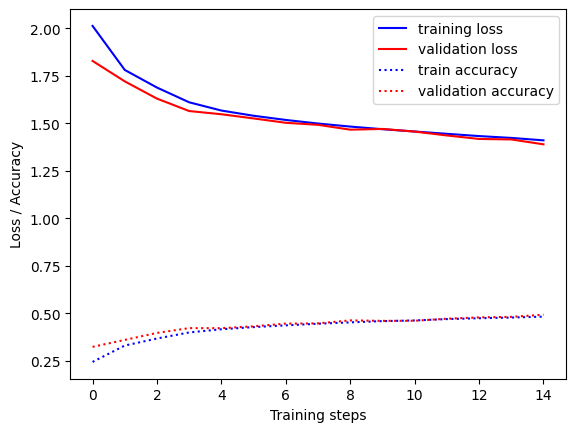

In [15]:
'''
1. Experiment

Learning rate: 0.0001
Architecture: [5,10,32,64]
Optimizer: Adam
'''

LEARNING_RATE = 0.0001

train, test, info = load_and_prep_cifar(batch_size=BATCH_SIZE, shuffle_buffer_size=SHUFFLE_BUFFER_SIZE)
model = CNN_Model(size_of_blocks=[5,10,32,64], lr=LEARNING_RATE, opt='adam')

# Define where to save the log
config_name= "Run-2"
train_log_path = f'logs/{config_name}/{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}/train'
test_log_path = f'logs/{config_name}/{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}/val'
# log writer for training metrics
train_summary_writer = tf.summary.create_file_writer(train_log_path)
# log writer for validation metrics
test_summary_writer = tf.summary.create_file_writer(test_log_path)


train_losses, train_accuracies, val_losses, val_accuracies = training_loop(model, train, test, 15, train_summary_writer, test_summary_writer)
visualization(train_losses, train_accuracies, val_losses, val_accuracies)

Epoch 0: 100%|██████████| 782/782 [00:17<00:00, 45.28it/s]


['loss: 1.8209043741226196', 'acc: 0.30880001187324524']
['val_loss: 1.6407331228256226', 'val_acc: 0.36800000071525574']


Epoch 1: 100%|██████████| 782/782 [00:15<00:00, 51.49it/s]


['loss: 1.5603712797164917', 'acc: 0.4202199876308441']
['val_loss: 1.4682104587554932', 'val_acc: 0.4625000059604645']


Epoch 2: 100%|██████████| 782/782 [00:14<00:00, 52.34it/s]


['loss: 1.4325628280639648', 'acc: 0.4740999937057495']
['val_loss: 1.383771538734436', 'val_acc: 0.49410000443458557']


Epoch 3: 100%|██████████| 782/782 [00:15<00:00, 51.93it/s]


['loss: 1.3393640518188477', 'acc: 0.5133399963378906']
['val_loss: 1.2995750904083252', 'val_acc: 0.5217000246047974']


Epoch 4: 100%|██████████| 782/782 [00:15<00:00, 51.85it/s]


['loss: 1.2427772283554077', 'acc: 0.5519000291824341']
['val_loss: 1.2116962671279907', 'val_acc: 0.5641999840736389']


Epoch 5: 100%|██████████| 782/782 [00:15<00:00, 50.34it/s]


['loss: 1.1639622449874878', 'acc: 0.579200029373169']
['val_loss: 1.1826047897338867', 'val_acc: 0.5752999782562256']


Epoch 6: 100%|██████████| 782/782 [00:15<00:00, 50.33it/s]


['loss: 1.095015048980713', 'acc: 0.6101400256156921']
['val_loss: 1.1567292213439941', 'val_acc: 0.5925999879837036']


Epoch 7: 100%|██████████| 782/782 [00:15<00:00, 52.12it/s]


['loss: 1.0398280620574951', 'acc: 0.627780020236969']
['val_loss: 1.1587579250335693', 'val_acc: 0.5990999937057495']


Epoch 8: 100%|██████████| 782/782 [00:15<00:00, 50.77it/s]


['loss: 0.9989300966262817', 'acc: 0.6433600187301636']
['val_loss: 1.1110202074050903', 'val_acc: 0.6129000186920166']


Epoch 9: 100%|██████████| 782/782 [00:14<00:00, 52.83it/s]


['loss: 0.95506352186203', 'acc: 0.6577600240707397']
['val_loss: 1.06312894821167', 'val_acc: 0.6273999810218811']


Epoch 10: 100%|██████████| 782/782 [00:14<00:00, 53.19it/s]


['loss: 0.917088508605957', 'acc: 0.6709399819374084']
['val_loss: 1.1021802425384521', 'val_acc: 0.6187999844551086']


Epoch 11: 100%|██████████| 782/782 [00:15<00:00, 51.57it/s]


['loss: 0.8888699412345886', 'acc: 0.6810200214385986']
['val_loss: 1.070319652557373', 'val_acc: 0.6334999799728394']


Epoch 12: 100%|██████████| 782/782 [00:15<00:00, 50.66it/s]


['loss: 0.8505421280860901', 'acc: 0.6956800222396851']
['val_loss: 1.1334140300750732', 'val_acc: 0.6208999752998352']


Epoch 13: 100%|██████████| 782/782 [00:15<00:00, 51.71it/s]


['loss: 0.8140936493873596', 'acc: 0.707099974155426']
['val_loss: 1.1001489162445068', 'val_acc: 0.6381999850273132']


Epoch 14: 100%|██████████| 782/782 [00:14<00:00, 52.15it/s]


['loss: 0.78496915102005', 'acc: 0.7170199751853943']
['val_loss: 1.149471640586853', 'val_acc: 0.6322000026702881']


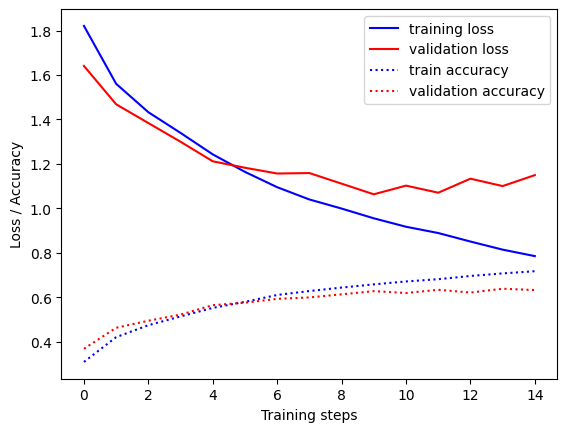

In [16]:
'''
2. Experiment

Learning rate: 0.002
Architecture: [5,10,32,64]
Optimizer: Adam
'''

LEARNING_RATE = 0.002

train, test, info = load_and_prep_cifar(batch_size=BATCH_SIZE, shuffle_buffer_size=SHUFFLE_BUFFER_SIZE)
model = CNN_Model(size_of_blocks=[5,10,32,64], lr=LEARNING_RATE, opt='adam')

# Define where to save the log
config_name= "Run-2"
train_log_path = f'logs/{config_name}/{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}/train'
test_log_path = f'logs/{config_name}/{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}/val'
# log writer for training metrics
train_summary_writer = tf.summary.create_file_writer(train_log_path)
# log writer for validation metrics
test_summary_writer = tf.summary.create_file_writer(test_log_path)


train_losses, train_accuracies, val_losses, val_accuracies = training_loop(model, train, test, 15, train_summary_writer, test_summary_writer)
visualization(train_losses, train_accuracies, val_losses, val_accuracies)

## 2.2 Architecture Experiments

Epoch 0: 100%|██████████| 782/782 [00:43<00:00, 18.17it/s]


['loss: 1.8469065427780151', 'acc: 0.3036800026893616']
['val_loss: 1.6356477737426758', 'val_acc: 0.3790000081062317']


Epoch 1: 100%|██████████| 782/782 [00:40<00:00, 19.22it/s]


['loss: 1.501494288444519', 'acc: 0.43869999051094055']
['val_loss: 1.3890317678451538', 'val_acc: 0.49000000953674316']


Epoch 2: 100%|██████████| 782/782 [00:40<00:00, 19.18it/s]


['loss: 1.3401178121566772', 'acc: 0.5051599740982056']
['val_loss: 1.3276340961456299', 'val_acc: 0.5206000208854675']


Epoch 3: 100%|██████████| 782/782 [00:40<00:00, 19.27it/s]


['loss: 1.2278577089309692', 'acc: 0.5519400238990784']
['val_loss: 1.2269328832626343', 'val_acc: 0.5572999715805054']


Epoch 4: 100%|██████████| 782/782 [00:40<00:00, 19.27it/s]


['loss: 1.1327459812164307', 'acc: 0.5882800221443176']
['val_loss: 1.0907377004623413', 'val_acc: 0.6075999736785889']


Epoch 5: 100%|██████████| 782/782 [00:40<00:00, 19.20it/s]


['loss: 1.0562829971313477', 'acc: 0.6169599890708923']
['val_loss: 1.0225509405136108', 'val_acc: 0.6277999877929688']


Epoch 6: 100%|██████████| 782/782 [00:40<00:00, 19.21it/s]


['loss: 0.9888032674789429', 'acc: 0.6421399712562561']
['val_loss: 0.9808741211891174', 'val_acc: 0.6474999785423279']


Epoch 7: 100%|██████████| 782/782 [00:40<00:00, 19.22it/s]


['loss: 0.9382122159004211', 'acc: 0.661300003528595']
['val_loss: 1.0080080032348633', 'val_acc: 0.6431000232696533']


Epoch 8: 100%|██████████| 782/782 [00:40<00:00, 19.27it/s]


['loss: 0.8868163228034973', 'acc: 0.6830199956893921']
['val_loss: 0.8754382133483887', 'val_acc: 0.6869999766349792']


Epoch 9: 100%|██████████| 782/782 [00:40<00:00, 19.20it/s]


['loss: 0.8351664543151855', 'acc: 0.701259970664978']
['val_loss: 0.8742902278900146', 'val_acc: 0.6919999718666077']


Epoch 10: 100%|██████████| 782/782 [00:40<00:00, 19.12it/s]


['loss: 0.7930070161819458', 'acc: 0.7159600257873535']
['val_loss: 0.8168205618858337', 'val_acc: 0.7142000198364258']


Epoch 11: 100%|██████████| 782/782 [00:40<00:00, 19.29it/s]


['loss: 0.7570086717605591', 'acc: 0.7311599850654602']
['val_loss: 0.8241825699806213', 'val_acc: 0.7103999853134155']


Epoch 12: 100%|██████████| 782/782 [00:41<00:00, 18.95it/s]


['loss: 0.7223738431930542', 'acc: 0.7427600026130676']
['val_loss: 0.789084792137146', 'val_acc: 0.7264999747276306']


Epoch 13: 100%|██████████| 782/782 [00:40<00:00, 19.18it/s]


['loss: 0.6833983659744263', 'acc: 0.757420003414154']
['val_loss: 0.7534409761428833', 'val_acc: 0.7360000014305115']


Epoch 14: 100%|██████████| 782/782 [00:42<00:00, 18.56it/s]


['loss: 0.6523615717887878', 'acc: 0.7689399719238281']
['val_loss: 0.8181842565536499', 'val_acc: 0.7218999862670898']


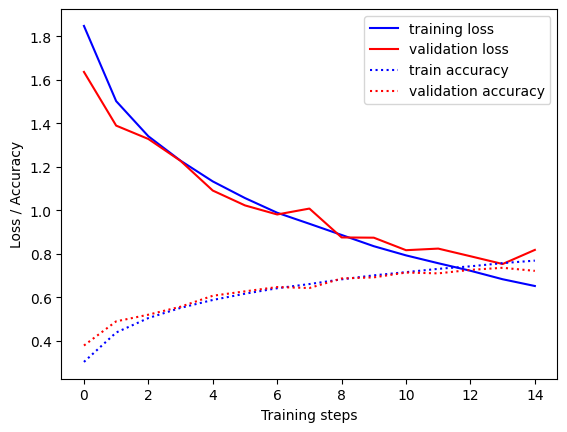

In [17]:
'''
3. Experiment

Learning rate: 0.0001
Architecture: [64,164,164,64]
Optimizer: Adam
'''

LEARNING_RATE = 0.0001

train, test, info = load_and_prep_cifar(batch_size=BATCH_SIZE, shuffle_buffer_size=SHUFFLE_BUFFER_SIZE)
model = CNN_Model(size_of_blocks=[64,164,164,64], lr=LEARNING_RATE, opt='adam')

# Define where to save the log
config_name= "Run-2"
train_log_path = f'logs/{config_name}/{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}/train'
test_log_path = f'logs/{config_name}/{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}/val'
# log writer for training metrics
train_summary_writer = tf.summary.create_file_writer(train_log_path)
# log writer for validation metrics
test_summary_writer = tf.summary.create_file_writer(test_log_path)


train_losses, train_accuracies, val_losses, val_accuracies = training_loop(model, train, test, 15, train_summary_writer, test_summary_writer)
visualization(train_losses, train_accuracies, val_losses, val_accuracies)

Epoch 0: 100%|██████████| 782/782 [00:23<00:00, 34.00it/s]


['loss: 1.7798082828521729', 'acc: 0.3255999982357025']
['val_loss: 1.4674925804138184', 'val_acc: 0.4512999951839447']


Epoch 1: 100%|██████████| 782/782 [00:21<00:00, 37.22it/s]


['loss: 1.3968197107315063', 'acc: 0.4820599853992462']
['val_loss: 1.2857345342636108', 'val_acc: 0.5338000059127808']


Epoch 2: 100%|██████████| 782/782 [00:20<00:00, 37.86it/s]


['loss: 1.1732984781265259', 'acc: 0.5739399790763855']
['val_loss: 1.121575951576233', 'val_acc: 0.6021999716758728']


Epoch 3: 100%|██████████| 782/782 [00:20<00:00, 37.97it/s]


['loss: 1.0295544862747192', 'acc: 0.631659984588623']
['val_loss: 1.0260560512542725', 'val_acc: 0.6340000033378601']


Epoch 4: 100%|██████████| 782/782 [00:20<00:00, 37.94it/s]


['loss: 0.9119376540184021', 'acc: 0.6748999953269958']
['val_loss: 0.9477071762084961', 'val_acc: 0.6650999784469604']


Epoch 5: 100%|██████████| 782/782 [00:20<00:00, 38.71it/s]


['loss: 0.8424256443977356', 'acc: 0.7024400234222412']
['val_loss: 0.9310694336891174', 'val_acc: 0.682699978351593']


Epoch 6: 100%|██████████| 782/782 [00:19<00:00, 39.16it/s]


['loss: 0.7824836373329163', 'acc: 0.7239000201225281']
['val_loss: 0.8844000101089478', 'val_acc: 0.6988999843597412']


Epoch 7: 100%|██████████| 782/782 [00:20<00:00, 38.25it/s]


['loss: 0.736972987651825', 'acc: 0.7396399974822998']
['val_loss: 0.9064058065414429', 'val_acc: 0.696399986743927']


Epoch 8: 100%|██████████| 782/782 [00:20<00:00, 38.79it/s]


['loss: 0.6976924538612366', 'acc: 0.7527400255203247']
['val_loss: 0.8421257734298706', 'val_acc: 0.7128999829292297']


Epoch 9: 100%|██████████| 782/782 [00:20<00:00, 38.55it/s]


['loss: 0.6691271662712097', 'acc: 0.7637199759483337']
['val_loss: 0.8497889041900635', 'val_acc: 0.7202000021934509']


Epoch 10: 100%|██████████| 782/782 [00:20<00:00, 38.86it/s]


['loss: 0.6367707848548889', 'acc: 0.7753400206565857']
['val_loss: 0.8437037467956543', 'val_acc: 0.7221999764442444']


Epoch 11: 100%|██████████| 782/782 [00:20<00:00, 39.03it/s]


['loss: 0.6084800958633423', 'acc: 0.785860002040863']
['val_loss: 0.820016086101532', 'val_acc: 0.7297000288963318']


Epoch 12: 100%|██████████| 782/782 [00:19<00:00, 39.20it/s]


['loss: 0.5820766091346741', 'acc: 0.7939199805259705']
['val_loss: 0.89008629322052', 'val_acc: 0.7161999940872192']


Epoch 13: 100%|██████████| 782/782 [00:20<00:00, 39.08it/s]


['loss: 0.5623540878295898', 'acc: 0.8003799915313721']
['val_loss: 0.8574192523956299', 'val_acc: 0.7300000190734863']


Epoch 14: 100%|██████████| 782/782 [00:20<00:00, 39.07it/s]


['loss: 0.5410550832748413', 'acc: 0.807919979095459']
['val_loss: 0.8645090460777283', 'val_acc: 0.7304999828338623']


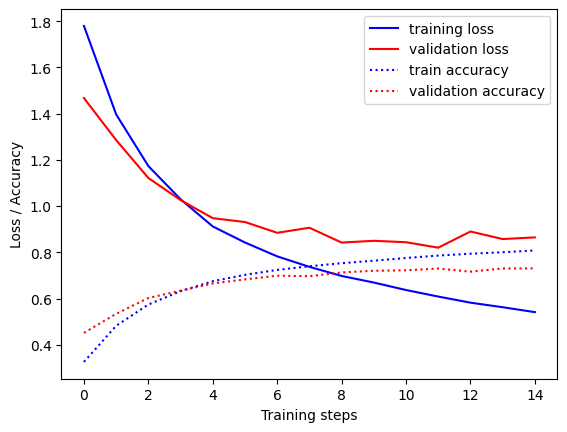

In [18]:
'''
4. Experiment

Learning rate: 0.002
Architecture: [64,164,164,64]
Optimizer: Adam
'''

LEARNING_RATE = 0.002

train, test, info = load_and_prep_cifar(batch_size=BATCH_SIZE, shuffle_buffer_size=SHUFFLE_BUFFER_SIZE)
model = CNN_Model(size_of_blocks=[64,32,32,64], lr=LEARNING_RATE, opt='adam')

# Define where to save the log
config_name= "Run-2"
train_log_path = f'logs/{config_name}/{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}/train'
test_log_path = f'logs/{config_name}/{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}/val'
# log writer for training metrics
train_summary_writer = tf.summary.create_file_writer(train_log_path)
# log writer for validation metrics
test_summary_writer = tf.summary.create_file_writer(test_log_path)


train_losses, train_accuracies, val_losses, val_accuracies = training_loop(model, train, test, 15, train_summary_writer, test_summary_writer)
visualization(train_losses, train_accuracies, val_losses, val_accuracies)

## 2.3 Optimizer Experiments

Epoch 0: 100%|██████████| 782/782 [00:16<00:00, 46.75it/s]


['loss: 2.3024258613586426', 'acc: 0.10000000149011612']
['val_loss: 2.3024301528930664', 'val_acc: 0.10000000149011612']


Epoch 1: 100%|██████████| 782/782 [00:14<00:00, 55.69it/s]


['loss: 2.3024230003356934', 'acc: 0.10000000149011612']
['val_loss: 2.3024256229400635', 'val_acc: 0.10000000149011612']


Epoch 2: 100%|██████████| 782/782 [00:13<00:00, 57.46it/s]


['loss: 2.3024182319641113', 'acc: 0.10000000149011612']
['val_loss: 2.3024213314056396', 'val_acc: 0.10000000149011612']


Epoch 3: 100%|██████████| 782/782 [00:13<00:00, 56.18it/s]


['loss: 2.30241322517395', 'acc: 0.10000000149011612']
['val_loss: 2.3024165630340576', 'val_acc: 0.10000000149011612']


Epoch 4: 100%|██████████| 782/782 [00:13<00:00, 57.04it/s]


['loss: 2.30241060256958', 'acc: 0.10000000149011612']
['val_loss: 2.302412986755371', 'val_acc: 0.10000000149011612']


Epoch 5: 100%|██████████| 782/782 [00:13<00:00, 56.74it/s]


['loss: 2.3024065494537354', 'acc: 0.10000000149011612']
['val_loss: 2.3024086952209473', 'val_acc: 0.10000000149011612']


Epoch 6: 100%|██████████| 782/782 [00:13<00:00, 56.46it/s]


['loss: 2.302400588989258', 'acc: 0.10000000149011612']
['val_loss: 2.3024039268493652', 'val_acc: 0.10000000149011612']


Epoch 7: 100%|██████████| 782/782 [00:14<00:00, 54.60it/s]


['loss: 2.302396535873413', 'acc: 0.10000000149011612']
['val_loss: 2.302398920059204', 'val_acc: 0.10000000149011612']


Epoch 8: 100%|██████████| 782/782 [00:14<00:00, 55.58it/s]


['loss: 2.30239200592041', 'acc: 0.10000000149011612']
['val_loss: 2.3023946285247803', 'val_acc: 0.10000000149011612']


Epoch 9: 100%|██████████| 782/782 [00:13<00:00, 57.10it/s]


['loss: 2.3023838996887207', 'acc: 0.10000000149011612']
['val_loss: 2.3023886680603027', 'val_acc: 0.10000000149011612']


Epoch 10: 100%|██████████| 782/782 [00:13<00:00, 57.38it/s]


['loss: 2.3023805618286133', 'acc: 0.10001999884843826']
['val_loss: 2.302384376525879', 'val_acc: 0.10000000149011612']


Epoch 11: 100%|██████████| 782/782 [00:13<00:00, 56.23it/s]


['loss: 2.3023757934570312', 'acc: 0.10001999884843826']
['val_loss: 2.3023793697357178', 'val_acc: 0.10000000149011612']


Epoch 12: 100%|██████████| 782/782 [00:13<00:00, 56.64it/s]


['loss: 2.302370071411133', 'acc: 0.10001999884843826']
['val_loss: 2.3023743629455566', 'val_acc: 0.10000000149011612']


Epoch 13: 100%|██████████| 782/782 [00:13<00:00, 57.38it/s]


['loss: 2.3023650646209717', 'acc: 0.10001999884843826']
['val_loss: 2.302370071411133', 'val_acc: 0.10010000318288803']


Epoch 14: 100%|██████████| 782/782 [00:13<00:00, 56.70it/s]


['loss: 2.3023617267608643', 'acc: 0.10001999884843826']
['val_loss: 2.302365779876709', 'val_acc: 0.10010000318288803']


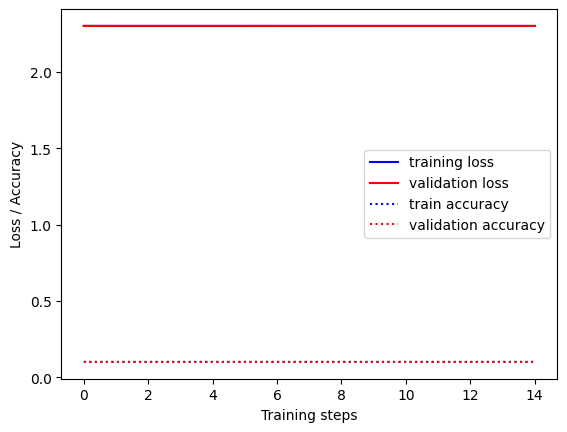

In [19]:
'''
5. Experiment

Learning rate: 0.0001
Architecture: [5,10,32,64]
Optimizer: SGD
'''

LEARNING_RATE = 0.0001
opt='sgd'

train, test, info = load_and_prep_cifar(batch_size=BATCH_SIZE, shuffle_buffer_size=SHUFFLE_BUFFER_SIZE)
model = CNN_Model(size_of_blocks=[5,10,32,64], lr=LEARNING_RATE, opt=opt)

# Define where to save the log
config_name= "Run-2"
train_log_path = f'logs/{config_name}/{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}/train'
test_log_path = f'logs/{config_name}/{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}/val'
# log writer for training metrics
train_summary_writer = tf.summary.create_file_writer(train_log_path)
# log writer for validation metrics
test_summary_writer = tf.summary.create_file_writer(test_log_path)


train_losses, train_accuracies, val_losses, val_accuracies = training_loop(model, train, test, 15, train_summary_writer, test_summary_writer)
visualization(train_losses, train_accuracies, val_losses, val_accuracies)

Epoch 0: 100%|██████████| 782/782 [00:16<00:00, 48.27it/s]


['loss: 2.3025784492492676', 'acc: 0.09651999920606613']
['val_loss: 2.3025171756744385', 'val_acc: 0.1251000016927719']


Epoch 1: 100%|██████████| 782/782 [00:14<00:00, 54.44it/s]


['loss: 2.302523136138916', 'acc: 0.10022000223398209']
['val_loss: 2.3024885654449463', 'val_acc: 0.10830000042915344']


Epoch 2: 100%|██████████| 782/782 [00:14<00:00, 55.09it/s]


['loss: 2.302500009536743', 'acc: 0.10010000318288803']
['val_loss: 2.3024652004241943', 'val_acc: 0.1143999993801117']


Epoch 3: 100%|██████████| 782/782 [00:13<00:00, 56.58it/s]


['loss: 2.302480459213257', 'acc: 0.10007999837398529']
['val_loss: 2.30244517326355', 'val_acc: 0.12160000205039978']


Epoch 4: 100%|██████████| 782/782 [00:13<00:00, 57.16it/s]


['loss: 2.302461862564087', 'acc: 0.10236000269651413']
['val_loss: 2.302424192428589', 'val_acc: 0.12030000239610672']


Epoch 5: 100%|██████████| 782/782 [00:13<00:00, 56.93it/s]


['loss: 2.3024380207061768', 'acc: 0.10155999660491943']
['val_loss: 2.302396059036255', 'val_acc: 0.12460000067949295']


Epoch 6: 100%|██████████| 782/782 [00:13<00:00, 56.18it/s]


['loss: 2.302405834197998', 'acc: 0.10837999731302261']
['val_loss: 2.3023593425750732', 'val_acc: 0.1225999966263771']


Epoch 7: 100%|██████████| 782/782 [00:15<00:00, 51.78it/s]


['loss: 2.302367925643921', 'acc: 0.11367999762296677']
['val_loss: 2.302319288253784', 'val_acc: 0.13179999589920044']


Epoch 8: 100%|██████████| 782/782 [00:14<00:00, 54.63it/s]


['loss: 2.302325963973999', 'acc: 0.11974000185728073']
['val_loss: 2.3022706508636475', 'val_acc: 0.12300000339746475']


Epoch 9: 100%|██████████| 782/782 [00:14<00:00, 55.19it/s]


['loss: 2.3022775650024414', 'acc: 0.12225999683141708']
['val_loss: 2.302215814590454', 'val_acc: 0.12780000269412994']


Epoch 10: 100%|██████████| 782/782 [00:13<00:00, 56.55it/s]


['loss: 2.302217960357666', 'acc: 0.1268399953842163']
['val_loss: 2.3021481037139893', 'val_acc: 0.12790000438690186']


Epoch 11: 100%|██████████| 782/782 [00:15<00:00, 50.70it/s]


['loss: 2.302142858505249', 'acc: 0.1282999962568283']
['val_loss: 2.302063465118408', 'val_acc: 0.12890000641345978']


Epoch 12: 100%|██████████| 782/782 [00:14<00:00, 54.98it/s]


['loss: 2.3020522594451904', 'acc: 0.1295199990272522']
['val_loss: 2.3019585609436035', 'val_acc: 0.13500000536441803']


Epoch 13: 100%|██████████| 782/782 [00:14<00:00, 53.94it/s]


['loss: 2.3019347190856934', 'acc: 0.13255999982357025']
['val_loss: 2.301825761795044', 'val_acc: 0.13760000467300415']


Epoch 14: 100%|██████████| 782/782 [00:14<00:00, 53.42it/s]


['loss: 2.301790475845337', 'acc: 0.1324400007724762']
['val_loss: 2.3016583919525146', 'val_acc: 0.14020000398159027']


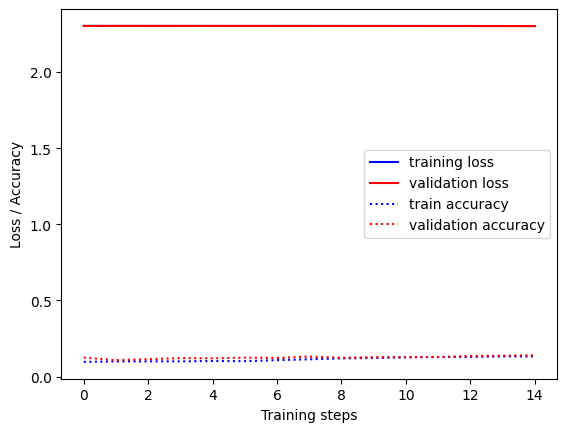

In [20]:
'''
6. Experiment

Learning rate: 0.002
Architecture: [5,10,32,64]
Optimizer: SGD
'''

LEARNING_RATE = 0.002
opt='sgd'

train, test, info = load_and_prep_cifar(batch_size=BATCH_SIZE, shuffle_buffer_size=SHUFFLE_BUFFER_SIZE)
model = CNN_Model(size_of_blocks=[5,10,32,64], lr=LEARNING_RATE, opt=opt)

# Define where to save the log
config_name= "Run-2"
train_log_path = f'logs/{config_name}/{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}/train'
test_log_path = f'logs/{config_name}/{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}/val'
# log writer for training metrics
train_summary_writer = tf.summary.create_file_writer(train_log_path)
# log writer for validation metrics
test_summary_writer = tf.summary.create_file_writer(test_log_path)


train_losses, train_accuracies, val_losses, val_accuracies = training_loop(model, train, test, 15, train_summary_writer, test_summary_writer)
visualization(train_losses, train_accuracies, val_losses, val_accuracies)

Epoch 0: 100%|██████████| 782/782 [00:43<00:00, 18.09it/s]


['loss: 2.302577495574951', 'acc: 0.09205999970436096']
['val_loss: 2.3025739192962646', 'val_acc: 0.09549999982118607']


Epoch 1: 100%|██████████| 782/782 [00:40<00:00, 19.45it/s]


['loss: 2.3025717735290527', 'acc: 0.09415999799966812']
['val_loss: 2.302569627761841', 'val_acc: 0.0982000008225441']


Epoch 2: 100%|██████████| 782/782 [00:40<00:00, 19.50it/s]


['loss: 2.302567720413208', 'acc: 0.09684000164270401']
['val_loss: 2.3025643825531006', 'val_acc: 0.10100000351667404']


Epoch 3: 100%|██████████| 782/782 [00:40<00:00, 19.49it/s]


['loss: 2.3025617599487305', 'acc: 0.09752000123262405']
['val_loss: 2.302558183670044', 'val_acc: 0.10300000011920929']


Epoch 4: 100%|██████████| 782/782 [00:40<00:00, 19.52it/s]


['loss: 2.302555561065674', 'acc: 0.1006999984383583']
['val_loss: 2.3025527000427246', 'val_acc: 0.10849999636411667']


Epoch 5: 100%|██████████| 782/782 [00:40<00:00, 19.52it/s]


['loss: 2.302553653717041', 'acc: 0.10335999727249146']
['val_loss: 2.3025479316711426', 'val_acc: 0.1120000034570694']


Epoch 6: 100%|██████████| 782/782 [00:40<00:00, 19.52it/s]


['loss: 2.302546739578247', 'acc: 0.10610000044107437']
['val_loss: 2.302541732788086', 'val_acc: 0.11590000241994858']


Epoch 7: 100%|██████████| 782/782 [00:40<00:00, 19.50it/s]


['loss: 2.3025405406951904', 'acc: 0.10939999669790268']
['val_loss: 2.3025360107421875', 'val_acc: 0.11620000004768372']


Epoch 8: 100%|██████████| 782/782 [00:40<00:00, 19.51it/s]


['loss: 2.302536964416504', 'acc: 0.11208000034093857']
['val_loss: 2.3025307655334473', 'val_acc: 0.1216999962925911']


Epoch 9: 100%|██████████| 782/782 [00:40<00:00, 19.52it/s]


['loss: 2.302529811859131', 'acc: 0.11528000235557556']
['val_loss: 2.3025259971618652', 'val_acc: 0.121799997985363']


Epoch 10: 100%|██████████| 782/782 [00:40<00:00, 19.51it/s]


['loss: 2.3025240898132324', 'acc: 0.11699999868869781']
['val_loss: 2.302520751953125', 'val_acc: 0.12219999730587006']


Epoch 11: 100%|██████████| 782/782 [00:39<00:00, 19.56it/s]


['loss: 2.3025195598602295', 'acc: 0.11823999881744385']
['val_loss: 2.302516460418701', 'val_acc: 0.12559999525547028']


Epoch 12: 100%|██████████| 782/782 [00:39<00:00, 19.55it/s]


['loss: 2.3025145530700684', 'acc: 0.12111999839544296']
['val_loss: 2.302511692047119', 'val_acc: 0.1274999976158142']


Epoch 13: 100%|██████████| 782/782 [00:39<00:00, 19.55it/s]


['loss: 2.3025097846984863', 'acc: 0.12460000067949295']
['val_loss: 2.3025054931640625', 'val_acc: 0.131400004029274']


Epoch 14: 100%|██████████| 782/782 [00:40<00:00, 19.53it/s]


['loss: 2.3025057315826416', 'acc: 0.1266999989748001']
['val_loss: 2.3025014400482178', 'val_acc: 0.13269999623298645']


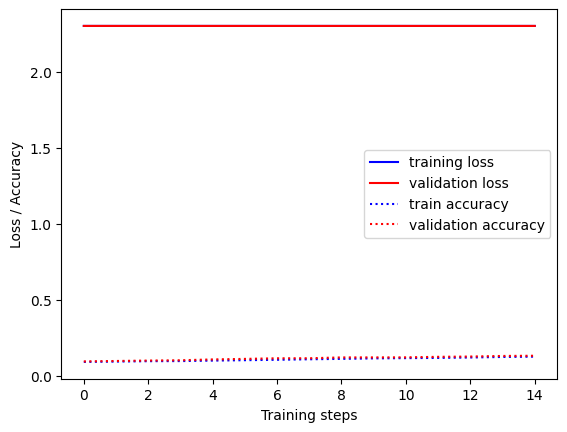

In [21]:
'''
7. Experiment

Learning rate: 0.0001
Architecture: [64,164,164,64]
Optimizer: SGD
'''

LEARNING_RATE = 0.0001
opt='sgd'

train, test, info = load_and_prep_cifar(batch_size=BATCH_SIZE, shuffle_buffer_size=SHUFFLE_BUFFER_SIZE)
model = CNN_Model(size_of_blocks=[64,164,164,64], lr=LEARNING_RATE, opt=opt)

# Define where to save the log
config_name= "Run-2"
train_log_path = f'logs/{config_name}/{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}/train'
test_log_path = f'logs/{config_name}/{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}/val'
# log writer for training metrics
train_summary_writer = tf.summary.create_file_writer(train_log_path)
# log writer for validation metrics
test_summary_writer = tf.summary.create_file_writer(test_log_path)


train_losses, train_accuracies, val_losses, val_accuracies = training_loop(model, train, test, 15, train_summary_writer, test_summary_writer)
visualization(train_losses, train_accuracies, val_losses, val_accuracies)

Epoch 0: 100%|██████████| 782/782 [00:42<00:00, 18.28it/s]


['loss: 2.302555799484253', 'acc: 0.10196000337600708']
['val_loss: 2.302511692047119', 'val_acc: 0.10000000149011612']


Epoch 1: 100%|██████████| 782/782 [00:40<00:00, 19.48it/s]


['loss: 2.302497148513794', 'acc: 0.10413999855518341']
['val_loss: 2.3024518489837646', 'val_acc: 0.10000000149011612']


Epoch 2: 100%|██████████| 782/782 [00:40<00:00, 19.44it/s]


['loss: 2.3024470806121826', 'acc: 0.1077599972486496']
['val_loss: 2.30240535736084', 'val_acc: 0.10000000149011612']


Epoch 3: 100%|██████████| 782/782 [00:40<00:00, 19.50it/s]


['loss: 2.3023977279663086', 'acc: 0.11395999789237976']
['val_loss: 2.3023457527160645', 'val_acc: 0.1005999967455864']


Epoch 4: 100%|██████████| 782/782 [00:40<00:00, 19.52it/s]


['loss: 2.3023250102996826', 'acc: 0.11875999718904495']
['val_loss: 2.3022642135620117', 'val_acc: 0.10000000149011612']


Epoch 5: 100%|██████████| 782/782 [00:40<00:00, 19.53it/s]


['loss: 2.302238941192627', 'acc: 0.12005999684333801']
['val_loss: 2.3021676540374756', 'val_acc: 0.10000000149011612']


Epoch 6: 100%|██████████| 782/782 [00:40<00:00, 19.50it/s]


['loss: 2.3021252155303955', 'acc: 0.12389999628067017']
['val_loss: 2.302032709121704', 'val_acc: 0.10440000146627426']


Epoch 7: 100%|██████████| 782/782 [00:40<00:00, 19.48it/s]


['loss: 2.301974058151245', 'acc: 0.12598000466823578']
['val_loss: 2.301856517791748', 'val_acc: 0.11999999731779099']


Epoch 8: 100%|██████████| 782/782 [00:40<00:00, 19.51it/s]


['loss: 2.3017759323120117', 'acc: 0.1336199939250946']
['val_loss: 2.3016257286071777', 'val_acc: 0.12060000002384186']


Epoch 9: 100%|██████████| 782/782 [00:40<00:00, 19.49it/s]


['loss: 2.3015048503875732', 'acc: 0.13750000298023224']
['val_loss: 2.3013083934783936', 'val_acc: 0.12890000641345978']


Epoch 10: 100%|██████████| 782/782 [00:39<00:00, 19.55it/s]


['loss: 2.3011314868927', 'acc: 0.14258000254631042']
['val_loss: 2.300856113433838', 'val_acc: 0.13349999487400055']


Epoch 11: 100%|██████████| 782/782 [00:39<00:00, 19.56it/s]


['loss: 2.3005802631378174', 'acc: 0.14905999600887299']
['val_loss: 2.3001794815063477', 'val_acc: 0.1517000049352646']


Epoch 12: 100%|██████████| 782/782 [00:40<00:00, 19.53it/s]


['loss: 2.29971981048584', 'acc: 0.15279999375343323']
['val_loss: 2.2990705966949463', 'val_acc: 0.17260000109672546']


Epoch 13: 100%|██████████| 782/782 [00:40<00:00, 19.50it/s]


['loss: 2.2982418537139893', 'acc: 0.1535000056028366']
['val_loss: 2.2970821857452393', 'val_acc: 0.16030000150203705']


Epoch 14: 100%|██████████| 782/782 [00:40<00:00, 19.50it/s]


['loss: 2.2953073978424072', 'acc: 0.14973999559879303']
['val_loss: 2.292720317840576', 'val_acc: 0.1444000005722046']


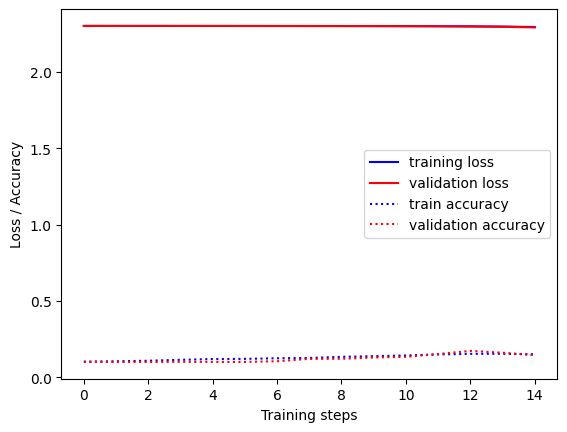

In [22]:
'''
8. Experiment

Learning rate: 0.002
Architecture: [64,164,164,64]
Optimizer: SGD
'''

LEARNING_RATE = 0.002
opt='sgd'

train, test, info = load_and_prep_cifar(batch_size=BATCH_SIZE, shuffle_buffer_size=SHUFFLE_BUFFER_SIZE)
model = CNN_Model(size_of_blocks=[64,164,164,64], lr=LEARNING_RATE, opt=opt)

# Define where to save the log
config_name= "Run-2"
train_log_path = f'logs/{config_name}/{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}/train'
test_log_path = f'logs/{config_name}/{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}/val'
# log writer for training metrics
train_summary_writer = tf.summary.create_file_writer(train_log_path)
# log writer for validation metrics
test_summary_writer = tf.summary.create_file_writer(test_log_path)


train_losses, train_accuracies, val_losses, val_accuracies = training_loop(model, train, test, 15, train_summary_writer, test_summary_writer)
visualization(train_losses, train_accuracies, val_losses, val_accuracies)